## 3d: Check if many glaciers get larger than the initial state

(results shortly mentioned in methods, but no figures from here are used)


- when just looking into the sum over the basins, we see that:
    - temporally (just for one or a few years), there are five (six) basins where the area gets larger after 2050 (2020) compared to the maximum area of the first 20 years. These five (six) basins are not part of our seven selected most dry and glaciated basins and are rather smaller-size basins ...
    - on a 21-yr rolling average, the basin's glacier area is always the largest in the first 21 years, so the area increase is only on a very short-term. Consequently the influence on the 

In [1]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import json
import oggm
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import geopandas as gpd

# get the correct colors for the different scenarios
from analysis_func import color_scenario, label_scenario, provide_reg_full_name_dict, color_scenario_poster

palette = sns.color_palette(color_scenario.values())

In [2]:
# Lower dpi for figures that are only displayed in the notebooks, but not later saved elsewhere to reduce the total files size
plt.rcParams['figure.dpi'] = 30  # Lower DPI for smaller file size

In [3]:
bc = 'bc_1980_2019'
df_scenario_common_basin = xr.open_dataset(f'../data/common_running_sum_all_basins_oversh_stab_2000_2500_{bc}.nc').sel(bias_correction=bc)
pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
f = open('/home/www/lschuster/provide/provide_glacier_regions/basin_ids_per_provide_region.json')
basins_per_preg = json.load(f)

df_scenario_common_basin['runoff_50_yr_avg'] = df_scenario_common_basin.runoff.isel(time=slice(0,-1)).rolling(min_periods=50, time=50, center=True).mean()
df_scenario_common_basin['runoff_20_yr_min'] = df_scenario_common_basin.runoff.isel(time=slice(0,-1)).rolling(min_periods=20, time=20, center=True).min()
df_scenario_common_basin['runoff_m_50_yr_avg'] = df_scenario_common_basin.runoff_monthly.isel(time=slice(0,-1)).rolling(min_periods=50, time=50, center=True).mean()
df_scenario_common_basin['melt_off_on_50_yr_avg'] = df_scenario_common_basin.melt_off_on.isel(time=slice(0,-1)).rolling(min_periods=50,
                                                                                                                        time=50, center=True).mean()

pd_runoff_scenario_rel_basin = (100*df_scenario_common_basin/df_scenario_common_basin.sel(time=2025)).runoff_50_yr_avg.to_dataframe('runoff_rel_2000_2050_%').reset_index()
pd_melt_off_on_scenario_rel_basin = (100*df_scenario_common_basin/df_scenario_common_basin.sel(time=2025)).melt_off_on_50_yr_avg.to_dataframe('melt_off_on_rel_2000_2050_%').reset_index()
pd_runoff_scenario_rel_basin_20_yr_min = (100*df_scenario_common_basin/df_scenario_common_basin.sel(time=2010)).runoff_20_yr_min.to_dataframe('runoff_min_rel_2000_2020_%').reset_index()
assert np.all(df_scenario_common_basin.runoff.sel(time=slice(2000,2019)).min(dim='time') == df_scenario_common_basin.sel(time=2010).runoff_20_yr_min)


## Start with basin-wide stuff

In [4]:
dtest = df_scenario_common_basin.sel(scenario = 'oversh_T30OS15').mean(dim='month_2d')

In [5]:
pd_basin_num.index = pd_basin_num.MRBID.astype(str)

**these basins have temporarily a larger area than before 2020**
(but just for a few years)

In [6]:
basin_larger_init = dtest.basin.where(dtest.area.idxmax(dim='time')>2050).dropna(dim='basin').squeeze().values
pd_basin_num.loc[basin_larger_init]

MRBID                                        RIVER_BASI CONTINENT  \
MRBID                                                                      
6219    6219                                        KALIXALVEN    Europe   
6255    6255  TORNEALVEN (also TORNIONJOKI, also TORNIONVAYLA)    Europe   
6223    6223                                             KUBAN    Europe   
2108    2108                                                OB      Asia   
2909    2909                                       HAR US NUUR      Asia   

                OCEAN         SEA  AREA_CALC  Shape_Leng  Shape_Area  \
MRBID                                                                  
6219   Atlantic Ocean  Baltic Sea    17094.6   16.452296    3.563221   
6255   Atlantic Ocean  Baltic Sea    40545.2   28.919025    8.685652   
6223   Atlantic Ocean   Black Sea    52441.2   17.116922    5.942039   
2108     Arctic Ocean    Kara Sea  3040606.1  168.355250  448.342075   
2909              ---         ---   229006.5   40.341037   27.677465   

       RGI_AREA                                           geometry  
MRBID                                                               
6219     38.496  POLYGON ((23.05833 66.575, 23.05609 66.57447, ...  
6255     34.257  POLYGON ((23.69167 68.84167, 23.70214 68.84102...  
6223    175.577  POLYGON ((41.0875 45.4125, 41.08843 45.40926, ...  
2108    763.493  POLYGON ((91.75 57.70417, 91.74542 57.70299, 9...  
2909    319.702  POLYGON ((89.81667 50.4125, 89.81758 50.40893,...

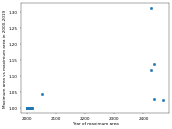

In [7]:
plt.plot(dtest.area.idxmax(dim='time'),
         dtest.area.max(dim='time')/dtest.area.sel(time=slice(2000,2019)).max(dim='time'),
         'o'
        )
plt.ylabel('Maximum area vs maximum area in 2000-2019')
plt.xlabel('Year of maximum area');
#/dtest.area.sel(time=slice(2000,2019)).max(dim='time')

**CHecks with 21-year rolling average area**

In [8]:
dtest_area_roll = dtest.area.rolling(time=21, center = True).mean().dropna(dim='time')

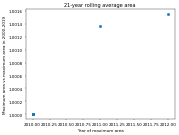

In [9]:
plt.plot(dtest_area_roll.idxmax(dim='time'),
         dtest_area_roll.max(dim='time')/dtest_area_roll.sel(time=2010),
         'o'
        )
plt.title('21-year rolling average area')
plt.ylabel('Maximum area vs maximum area in 2000-2019')
plt.xlabel('Year of maximum area');

## Per-glacier stuff

In [10]:
path_per_glac = '../A_runs_pre_postprocessing/output/'

In [11]:
# per_glacier
dpg_area_d = {}
dpg_runoff_d = {}
for rgi_reg in np.arange(1,19.1,1):
    rgi_reg = int(rgi_reg)
    dpg = xr.open_mfdataset(f'{path_per_glac}RGI{rgi_reg:02d}/run_hydro_w5e5_gcm_merged_from_2000_gfdl-esm2m_oversh_T30OS15_endyr_2500_bc_1980_2019_rgi{rgi_reg:02d}_*.nc')
    dpg_area_d[f'{rgi_reg:02d}'] = dpg.area.load().dropna(dim='rgi_id', how='all')
    dpg['runoff'] = dpg['melt_off_glacier'] + dpg['melt_on_glacier'] + dpg['liq_prcp_off_glacier'] + dpg['liq_prcp_on_glacier']
    dpg_runoff_d[f'{rgi_reg:02d}'] = dpg.runoff.load().dropna(dim='rgi_id', how='all')


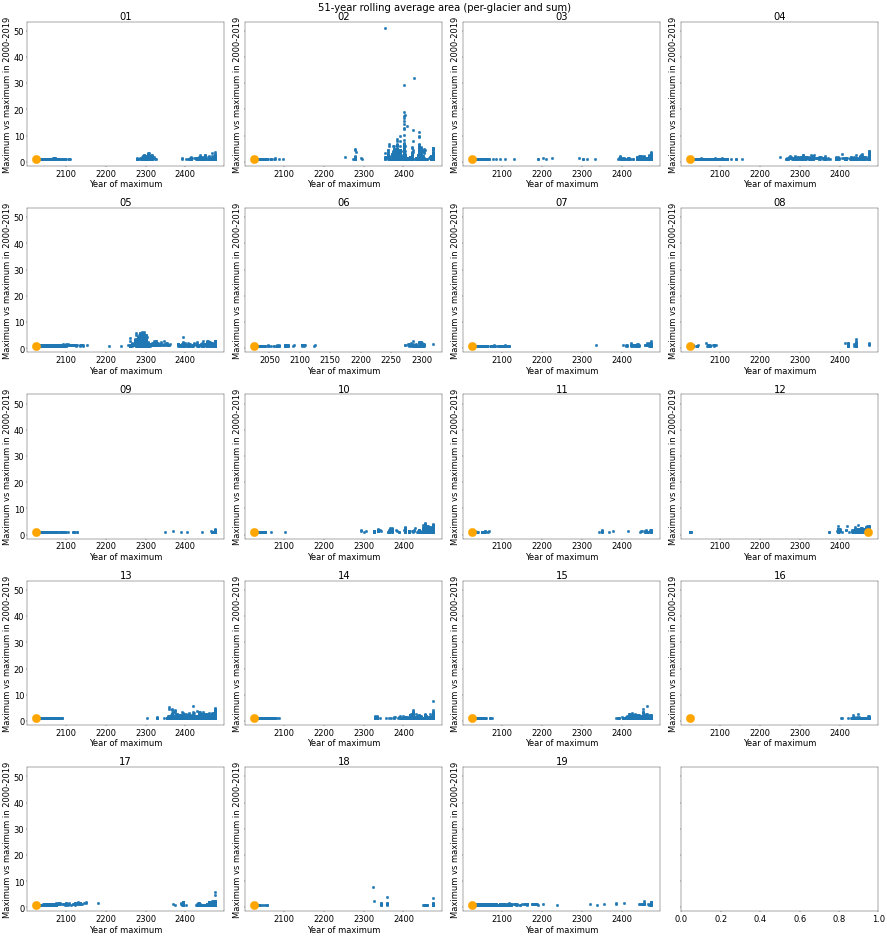

In [12]:
plt.rc('font', size=20)
fig, axs = plt.subplots(5,4, figsize=(30,32), sharey=True) #, sharex=True)
axs = axs.flatten()
for j,rgi_reg in enumerate(dpg_area_d.keys()):
    ax = axs[j]
    
    dpg_area = dpg_area_d[rgi_reg]
    dpg_area_roll = dpg_area.rolling(time=51, center = True).mean().dropna(dim='time')
    
    ax.plot(dpg_area_roll.idxmax(dim='time'),
         dpg_area_roll.max(dim='time')/dpg_area_roll.sel(time=2025),
         'o'
        )
    
    dpg_area_roll_sum = dpg_area_roll.sum(dim='rgi_id')
    ax.plot(dpg_area_roll_sum.idxmax(dim='time'),
         dpg_area_roll_sum.max(dim='time')/dpg_area_roll_sum.sel(time=2025),
         'o', ms=20,color='orange'
        )
    ax.set_title(f'{rgi_reg}')
    ax.set_ylabel('Maximum vs maximum in 2000-2019')
    ax.set_xlabel('Year of maximum');
plt.suptitle('51-year rolling average area (per-glacier and sum)')
plt.tight_layout()

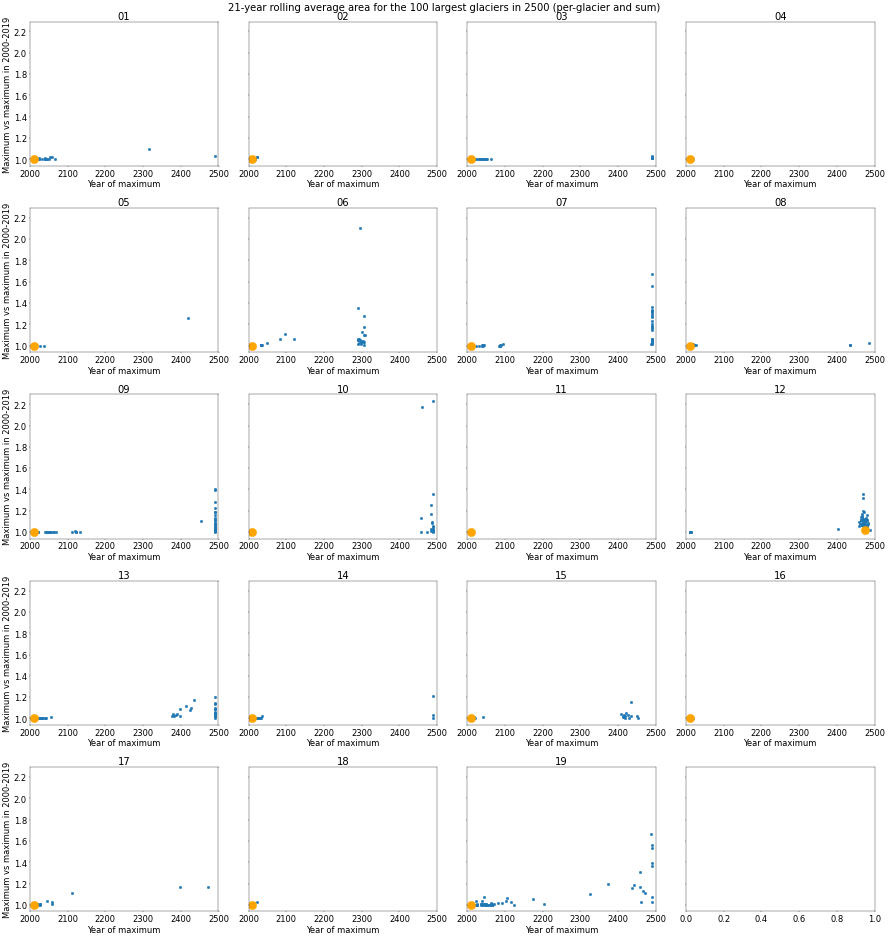

In [13]:
plt.rc('font', size=20)
fig, axs = plt.subplots(5,4, figsize=(30,32), sharey=True) #, sharex=True)
axs = axs.flatten()
for j,rgi_reg in enumerate(dpg_area_d.keys()):
    ax = axs[j]
    dpg_area = dpg_area_d[rgi_reg]
    dpg_area_roll = dpg_area.rolling(time=21, center = True).mean().dropna(dim='time')
    dpg_area_roll
    # only select the 100 largest glaciers in basically 2500
    glac_largest_ind = dpg_area_roll.isel(time=-1).to_dataframe().sort_values(by='area')[-100:].index
    dpg_area_roll_sel = dpg_area_roll.sel(rgi_id = glac_largest_ind)
    ax.plot(dpg_area_roll_sel.idxmax(dim='time'),
         dpg_area_roll_sel.max(dim='time')/dpg_area_roll_sel.sel(time=2010),
         'o'
        )
    
    dpg_area_roll_sel_sum = dpg_area_roll_sel.sum(dim='rgi_id')
    ax.plot(dpg_area_roll_sel_sum.idxmax(dim='time'),
         dpg_area_roll_sel_sum.max(dim='time')/dpg_area_roll_sel_sum.sel(time=2010),
         'o', ms=20,color='orange'
        )
    ax.set_title(f'{rgi_reg}')
    if j in [0,4,8,12,16]:
        ax.set_ylabel('Maximum vs maximum in 2000-2019')
    ax.set_xlabel('Year of maximum');
    ax.set_xlim([2000,2500])
plt.suptitle('21-year rolling average area for the 100 largest glaciers in 2500 (per-glacier and sum)')
plt.tight_layout()

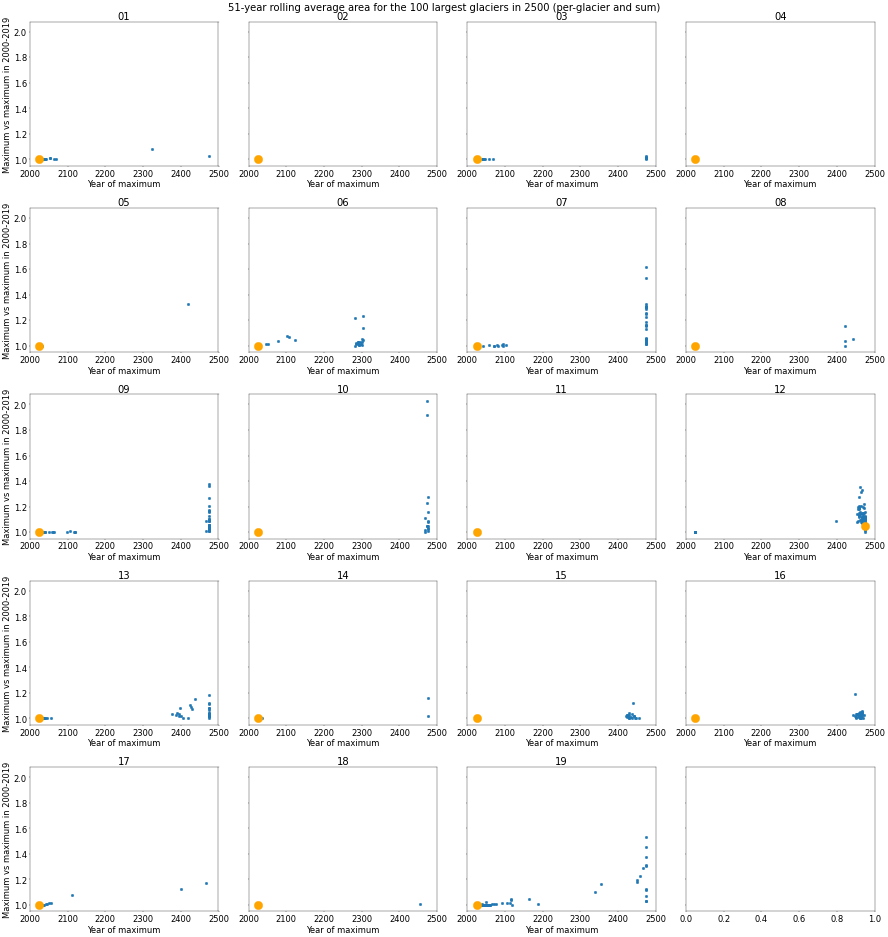

In [14]:
plt.rc('font', size=20)
fig, axs = plt.subplots(5,4, figsize=(30,32), sharey=True) #, sharex=True)
axs = axs.flatten()
for j,rgi_reg in enumerate(dpg_area_d.keys()):
    ax = axs[j]
    dpg_area = dpg_area_d[rgi_reg]
    dpg_area_roll = dpg_area.rolling(time=51, center = True).mean().dropna(dim='time')
    dpg_area_roll
    # only select the 100 largest glaciers in basically 2500
    glac_largest_ind = dpg_area_roll.isel(time=-1).to_dataframe().sort_values(by='area')[-100:].index
    dpg_area_roll_sel = dpg_area_roll.sel(rgi_id = glac_largest_ind)
    ax.plot(dpg_area_roll_sel.idxmax(dim='time'),
         dpg_area_roll_sel.max(dim='time')/dpg_area_roll_sel.sel(time=2025),
         'o'
        )
    
    dpg_area_roll_sel_sum = dpg_area_roll_sel.sum(dim='rgi_id')
    ax.plot(dpg_area_roll_sel_sum.idxmax(dim='time'),
         dpg_area_roll_sel_sum.max(dim='time')/dpg_area_roll_sel_sum.sel(time=2025),
         'o', ms=20,color='orange'
        )
    ax.set_title(f'{rgi_reg}')
    if j in [0,4,8,12,16]:
        ax.set_ylabel('Maximum vs maximum in 2000-2019')
    ax.set_xlabel('Year of maximum');
    ax.set_xlim([2000,2500])
plt.suptitle('51-year rolling average area for the 100 largest glaciers in 2500 (per-glacier and sum)')
plt.tight_layout()

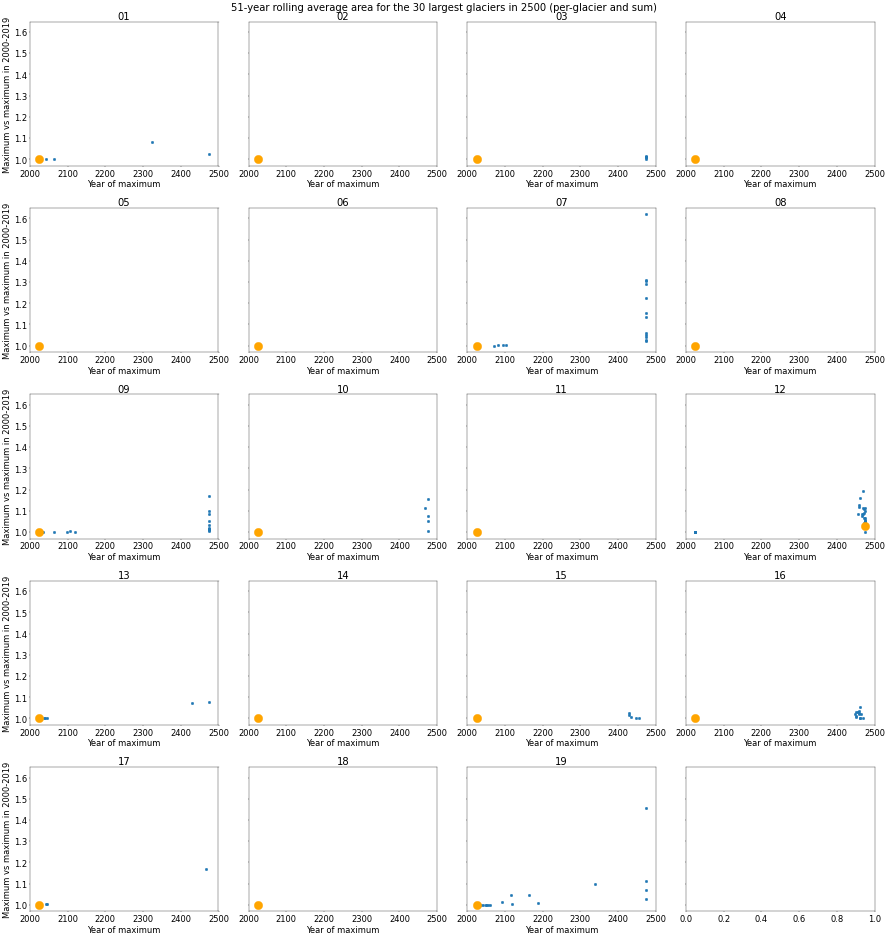

In [15]:
plt.rc('font', size=20)
fig, axs = plt.subplots(5,4, figsize=(30,32), sharey=True) #, sharex=True)
axs = axs.flatten()
for j,rgi_reg in enumerate(dpg_area_d.keys()):
    ax = axs[j]
    dpg_area = dpg_area_d[rgi_reg]
    dpg_area_roll = dpg_area.rolling(time=51, center = True).mean().dropna(dim='time')
    dpg_area_roll
    # only select the 30 largest glaciers in basically 2500
    glac_largest_ind = dpg_area_roll.isel(time=-1).to_dataframe().sort_values(by='area')[-30:].index
    dpg_area_roll_sel = dpg_area_roll.sel(rgi_id = glac_largest_ind)
    ax.plot(dpg_area_roll_sel.idxmax(dim='time'),
         dpg_area_roll_sel.max(dim='time')/dpg_area_roll_sel.sel(time=2025),
         'o'
        )
    
    dpg_area_roll_sel_sum = dpg_area_roll_sel.sum(dim='rgi_id')
    ax.plot(dpg_area_roll_sel_sum.idxmax(dim='time'),
         dpg_area_roll_sel_sum.max(dim='time')/dpg_area_roll_sel_sum.sel(time=2025),
         'o', ms=20,color='orange'
        )
    ax.set_title(f'{rgi_reg}')
    if j in [0,4,8,12,16]:
        ax.set_ylabel('Maximum vs maximum in 2000-2019')
    ax.set_xlabel('Year of maximum');
    ax.set_xlim([2000,2500])
plt.suptitle('51-year rolling average area for the 30 largest glaciers in 2500 (per-glacier and sum)')
plt.tight_layout()

**ok, let's check it for single glaciers**

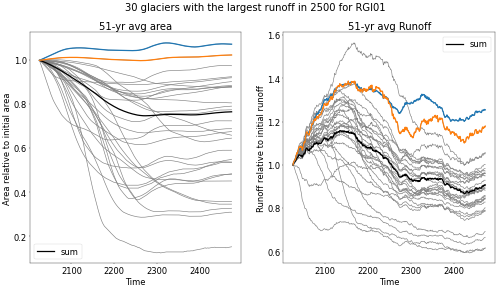

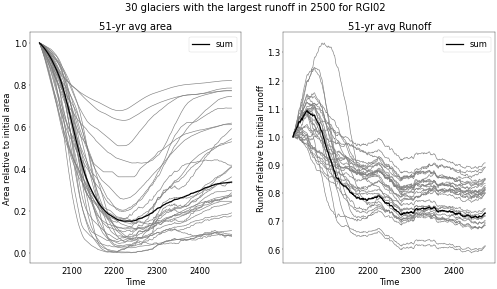

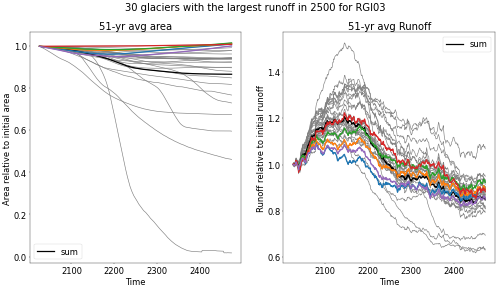

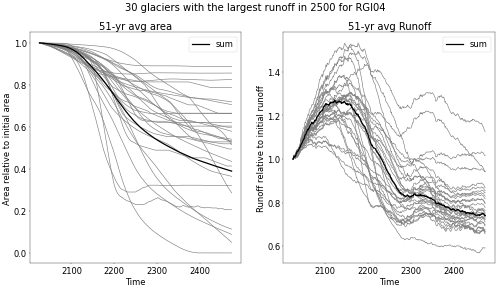

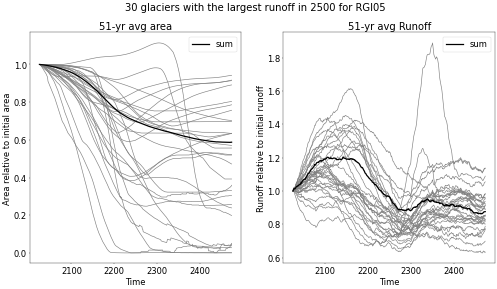

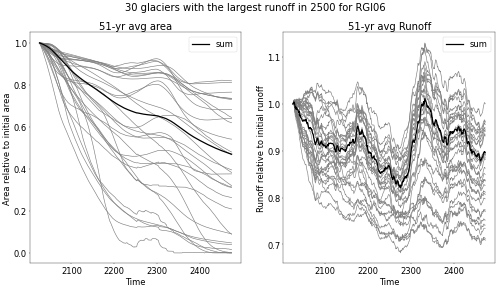

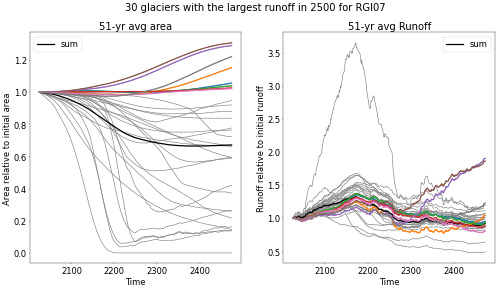

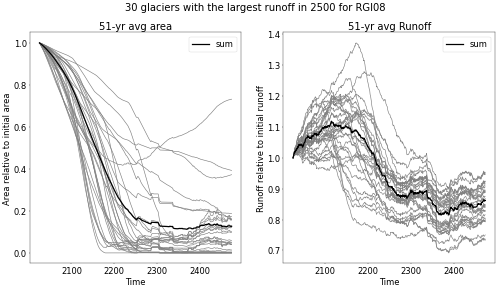

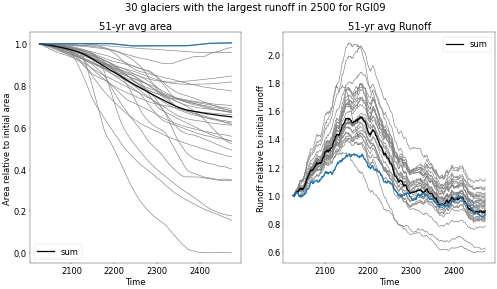

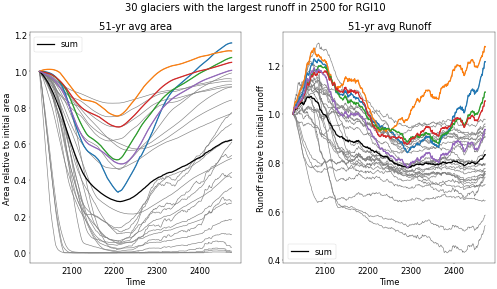

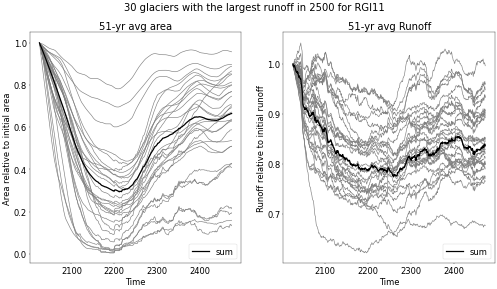

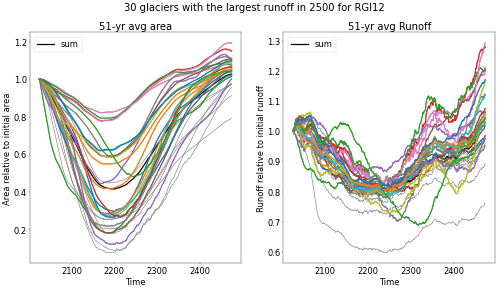

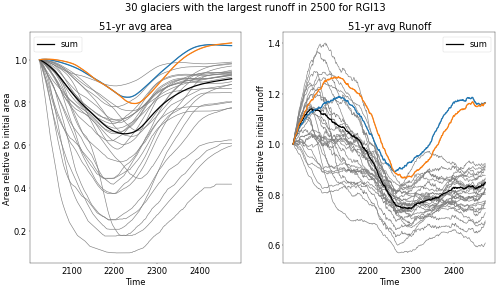

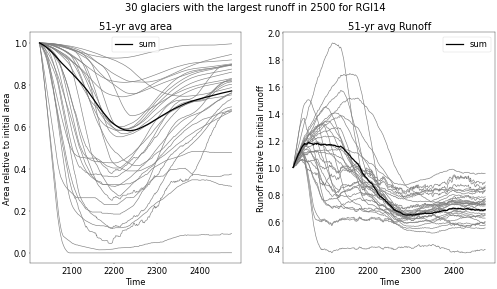

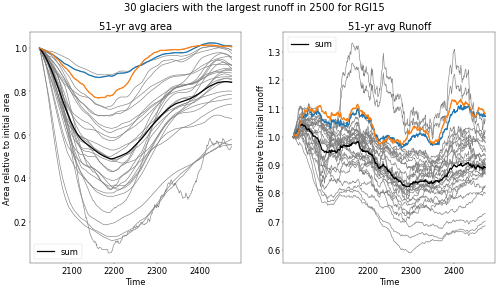

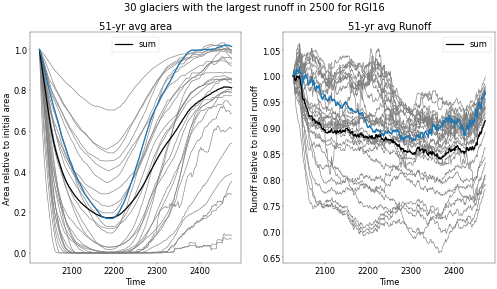

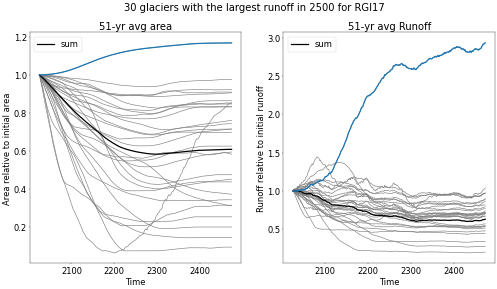

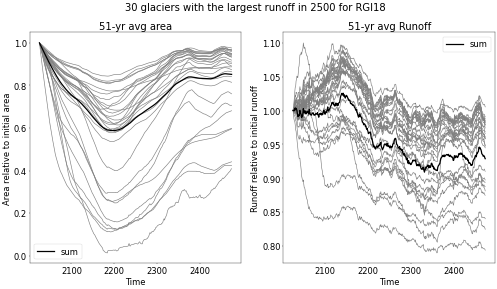

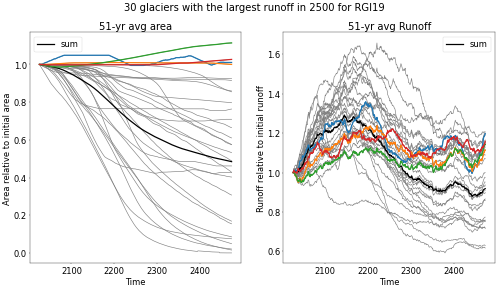

In [16]:
for rgi_reg in dpg_area_d.keys():
    dpg_runoff_sel = dpg_runoff_d[rgi_reg]
    dpg_runoff_roll = dpg_runoff_sel.rolling(time=51, center = True).mean().dropna(dim='time')

    dpg_area_sel = dpg_area_d[rgi_reg]
    dpg_area_roll = dpg_area_sel.rolling(time=51, center = True).mean().dropna(dim='time')

    # only select the 30 glaciers with largest runoff in basically 2500
    glac_largest_runoff_ind = dpg_runoff_roll.isel(time=-1).to_dataframe().sort_values(by='runoff')[-30:].index
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    sel = dpg_area_roll.sel(rgi_id = glac_largest_runoff_ind)/dpg_area_roll.sel(rgi_id = glac_largest_runoff_ind).isel(time=0)
    sel_sum = dpg_area_roll.sel(rgi_id = glac_largest_runoff_ind).sum(dim='rgi_id')/dpg_area_roll.sel(rgi_id = glac_largest_runoff_ind).isel(time=0).sum(dim='rgi_id')
    plt.plot(dpg_area_roll.time, sel, color = 'grey');
    plt.plot(dpg_area_roll.time, sel_sum, lw=3, color='black', label='sum');
    sel_above1 = sel.where(sel.isel(time=-1)>1).dropna(dim='rgi_id')
    plt.plot(dpg_area_roll.time,
             sel_above1, lw=3) #color = 'grey');
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Area relative to initial area')
    plt.title('51-yr avg area')

    plt.subplot(122)
    sel2_sum = dpg_runoff_roll.sel(rgi_id = glac_largest_runoff_ind).sum(dim='rgi_id')/dpg_runoff_roll.sel(rgi_id = glac_largest_runoff_ind).isel(time=0).sum(dim='rgi_id')
    sel2 = dpg_runoff_roll.sel(rgi_id = glac_largest_runoff_ind)/dpg_runoff_roll.sel(rgi_id = glac_largest_runoff_ind).isel(time=0)

    plt.plot(dpg_runoff_roll.time, sel2, color = 'grey')

    plt.plot(dpg_runoff_roll.time, sel2_sum, lw=3, color='black', label='sum');

    plt.plot(dpg_runoff_roll.time,
             sel2.sel(rgi_id = sel_above1.rgi_id),
            lw=3) #color = 'grey');
    plt.legend()

    plt.xlabel('Time')
    plt.ylabel('Runoff relative to initial runoff')
    plt.title('51-yr avg Runoff')
    # plt.tight_layout()
    plt.suptitle(f'30 glaciers with the largest runoff in 2500 for RGI{rgi_reg}')

- colors describe glaciers with a larger final area than initial area
- every thin grey line is one of the 30 glaciers with the largest glacier runoff at the end 

**now the same, but instead showing the 30 glaciers with the largest area in 2500**

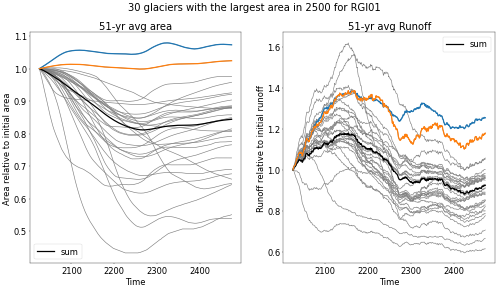

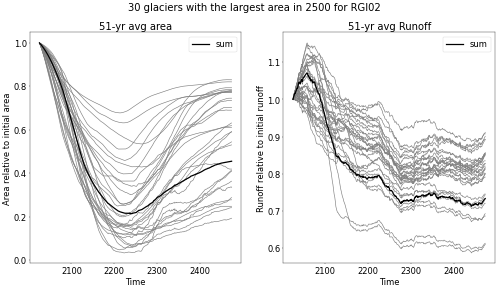

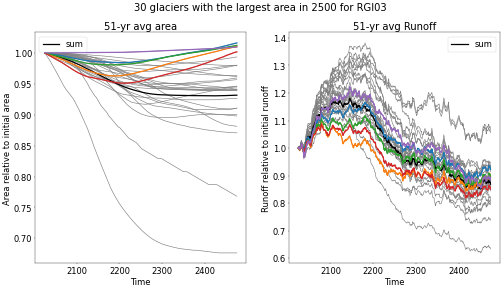

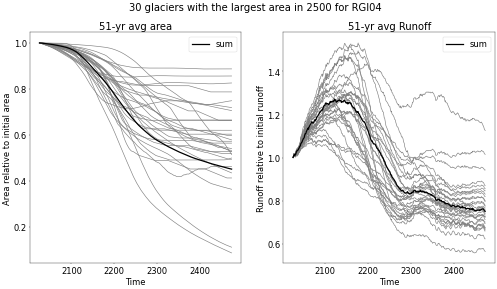

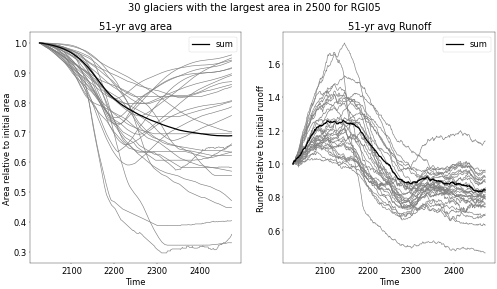

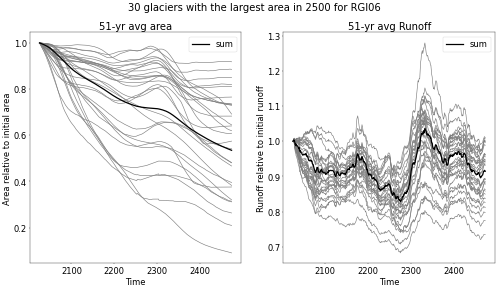

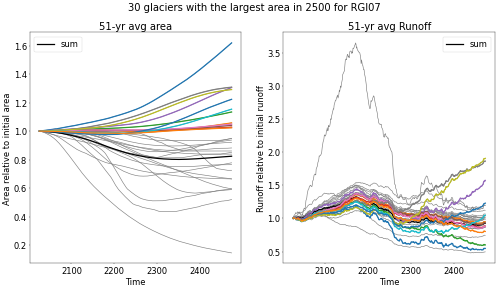

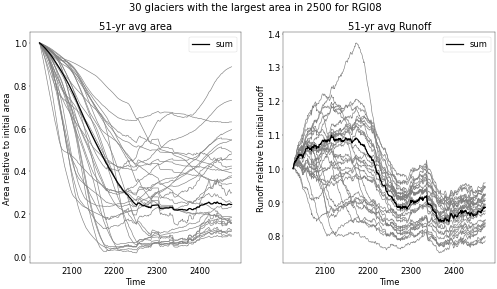

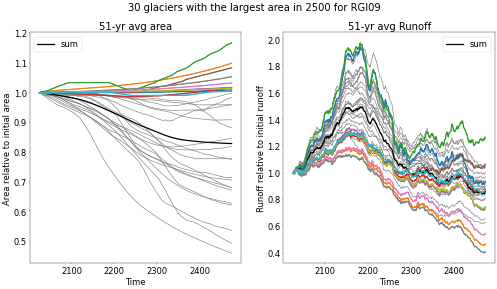

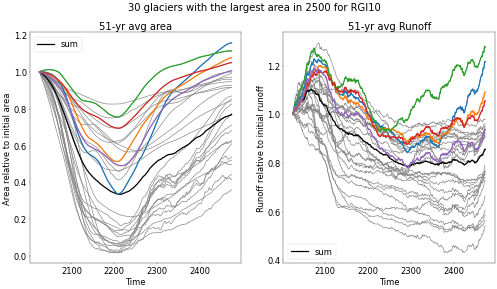

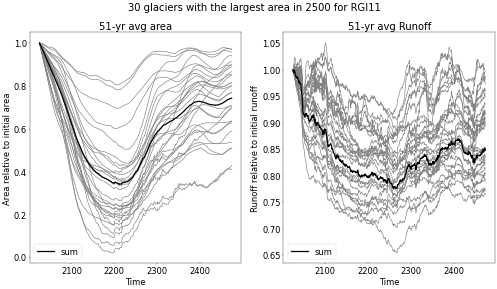

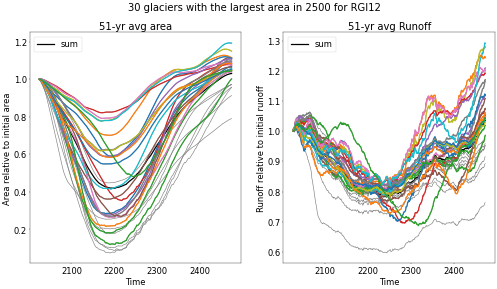

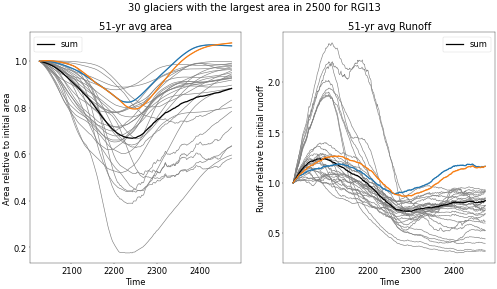

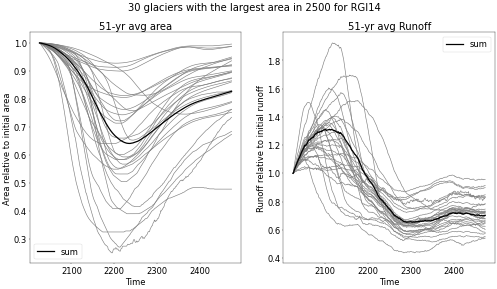

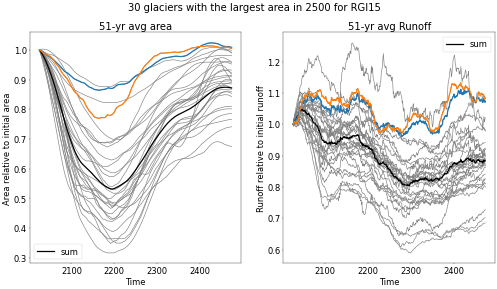

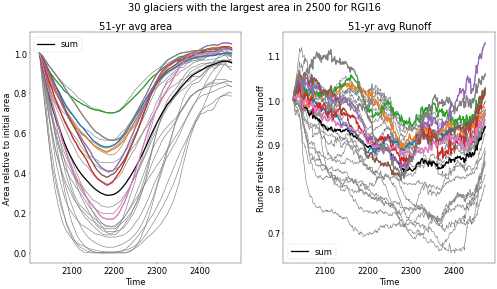

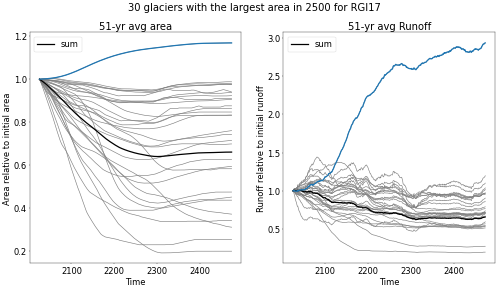

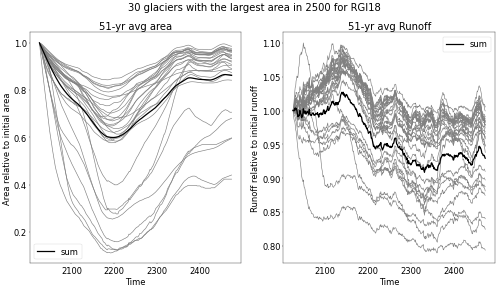

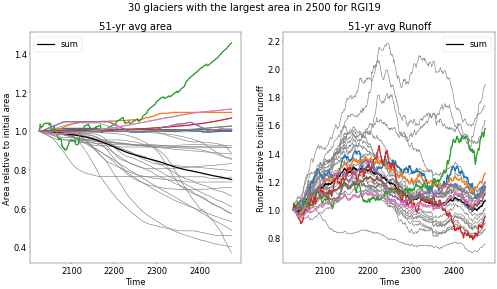

In [17]:
for rgi_reg in dpg_area_d.keys():
    dpg_runoff_sel = dpg_runoff_d[rgi_reg]
    dpg_runoff_roll = dpg_runoff_sel.rolling(time=51, center = True).mean().dropna(dim='time')

    dpg_area_sel = dpg_area_d[rgi_reg]
    dpg_area_roll = dpg_area_sel.rolling(time=51, center = True).mean().dropna(dim='time')

    # only select the 30 glaciers with largest area in basically 2500
    glac_largest_area_ind = dpg_area_roll.isel(time=-1).to_dataframe().sort_values(by='area')[-30:].index
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    sel = dpg_area_roll.sel(rgi_id = glac_largest_area_ind)/dpg_area_roll.sel(rgi_id = glac_largest_area_ind).isel(time=0)
    sel_sum = dpg_area_roll.sel(rgi_id = glac_largest_area_ind).sum(dim='rgi_id')/dpg_area_roll.sel(rgi_id = glac_largest_area_ind).isel(time=0).sum(dim='rgi_id')
    plt.plot(dpg_area_roll.time, sel, color = 'grey');
    plt.plot(dpg_area_roll.time, sel_sum, lw=3, color='black', label='sum');
    sel_above1 = sel.where(sel.isel(time=-1)>1).dropna(dim='rgi_id')
    plt.plot(dpg_area_roll.time,
             sel_above1, lw=3) #color = 'grey');
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Area relative to initial area')
    plt.title('51-yr avg area')

    plt.subplot(122)
    sel2_sum = dpg_runoff_roll.sel(rgi_id = glac_largest_area_ind).sum(dim='rgi_id')/dpg_runoff_roll.sel(rgi_id = glac_largest_area_ind).isel(time=0).sum(dim='rgi_id')
    sel2 = dpg_runoff_roll.sel(rgi_id = glac_largest_area_ind)/dpg_runoff_roll.sel(rgi_id = glac_largest_area_ind).isel(time=0)

    plt.plot(dpg_runoff_roll.time, sel2, color = 'grey')

    plt.plot(dpg_runoff_roll.time, sel2_sum, lw=3, color='black', label='sum');

    plt.plot(dpg_runoff_roll.time,
             sel2.sel(rgi_id = sel_above1.rgi_id),
            lw=3) #color = 'grey');
    plt.legend()

    plt.xlabel('Time')
    plt.ylabel('Runoff relative to initial runoff')
    plt.title('51-yr avg Runoff')
    # plt.tight_layout()
    plt.suptitle(f'30 glaciers with the largest area in 2500 for RGI{rgi_reg}')